<a href="https://colab.research.google.com/github/eojo91/ds2_2023_summer_ml_project1/blob/joonhoon.lee/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
## 목차
1. [Project Overview](#1.-Project-Overview)
2. [Data Preparation](#2.-Data-Preparation)
3. [Feature Extraction](#3.-Feature-Extraction)
4. [Classifiers](#4.-Classifiers)
5. [Cross-validation with Subjects](#5.-Cross-validation-with-Subjects)

### 1. Project Overview
- 5초간 손목의 가속도계 센서 데이터를 이용해서 그 사람의 행동을 예측하는 분류기를 만듭니다.

### Import libraries

In [1]:
import pickle
from urllib.request import urlopen

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score, LeaveOneGroupOut
%matplotlib inline

### Data Load

In [2]:
def load_data(local=True):
    """
    For colab, use local = False.
    It takes a few minutes to download.
    """
    if local:
        DATA_PATH = 'data/train.pkl'
        with open(DATA_PATH, 'rb') as f:
            df = pickle.load(f)
    else:
        DATA_URL = 'https://gitlab.com/machine-learning-course1/ml-project-samsung-2023-summer/-/raw/master/data/train.pkl?inline=false'
        df = pickle.load(urlopen(DATA_URL))

    X        = np.stack(df['Data'])
    Y        = np.stack(df['Motion'])
    Subjects = np.stack(df['Subject'])

    return X, Y, Subjects

In [3]:
X, Y, Subjects = load_data(local=False)

print(f'X: {X.shape}  Y: {Y.shape}  Subjects: {Subjects.shape}')
print(f'Motions: {sorted(set(Y))}')
print(f'Subjects: {sorted(set(Subjects))}')

X: (13940, 500, 3)  Y: (13940,)  Subjects: (13940,)
Motions: ['Nordic walking', 'ascending stairs', 'cycling', 'descending stairs', 'ironing', 'lying', 'rope jumping', 'running', 'sitting', 'standing', 'vacuum cleaning', 'walking']
Subjects: [3, 4, 5, 6, 7, 8, 9]


### 평균, 분산 등 비교

In [4]:
from scipy.fft import fft
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.signal import correlate
from scipy.spatial.distance import euclidean


from tqdm import tnrange, tqdm_notebook  #이터레이션 돌면서 얼마나 걸리는지를 보여줌.

import time



def extract_features(X_sample: np.ndarray) -> np.ndarray:
    """
    Extract features from a single sample

    Parameters
    ----------
    X_sample : array of shape (500, 3)
        100Hz * 5 seconds => 500
        3 axis (x, y, z)  => 3

    Returns
    -------
    features : array with (p,) shape
        Extracted features from X_sample
    """
    assert X_sample.shape != (500, 3)

    #################### TODO: Extract more features ####################

    # Extract time domain features
    mean_val = np.mean(X_sample, axis=0)
    min_val = np.min(X_sample, axis=0)
    max_val = np.max(X_sample, axis=0)
    std_dev = np.std(X_sample, axis=0)

    features = np.hstack([
        mean_val,
        min_val,
        max_val,
        std_dev
    ])

    ######################################################################

    return features

In [ ]:
import seaborn as sns
import pandas as pd

features = extract_features(X)
print(features.shape)
df = pd.DataFrame(features)
df.columns = ['mean_x', 'mean_y', 'mean_z', 'min_x', 'min_y', 'min_z', 'max_x', 'max_y', 'max_z', 'std_x', 'std_y', 'std_z']
df.head()

(500, 12)


,mean_x,mean_y,mean_z,min_x,min_y,min_z,max_x,max_y,max_z,std_x,std_y,std_z
0,-5.077356,2.912010,3.740755,-89.196503,-64.362297,-43.417301,21.548599,128.190002,43.650600,6.216705,7.108395,3.896932
1,-5.056980,2.910373,3.735488,-97.437897,-64.118896,-56.085701,24.027399,109.931000,40.247700,6.136708,6.987845,3.948894
2,-5.037217,2.936892,3.724514,-71.700104,-66.519798,-56.270901,29.249800,130.903000,24.842501,6.092940,7.074533,3.936083
3,-5.033074,2.953660,3.720580,-87.516197,-78.707603,-47.889099,25.603600,155.048004,42.900700,6.131937,7.231927,3.955787
4,-5.043208,2.972685,3.724968,-60.099098,-64.787102,-50.562801,20.666500,154.845001,38.034599,6.097255,7.314045,3.945177


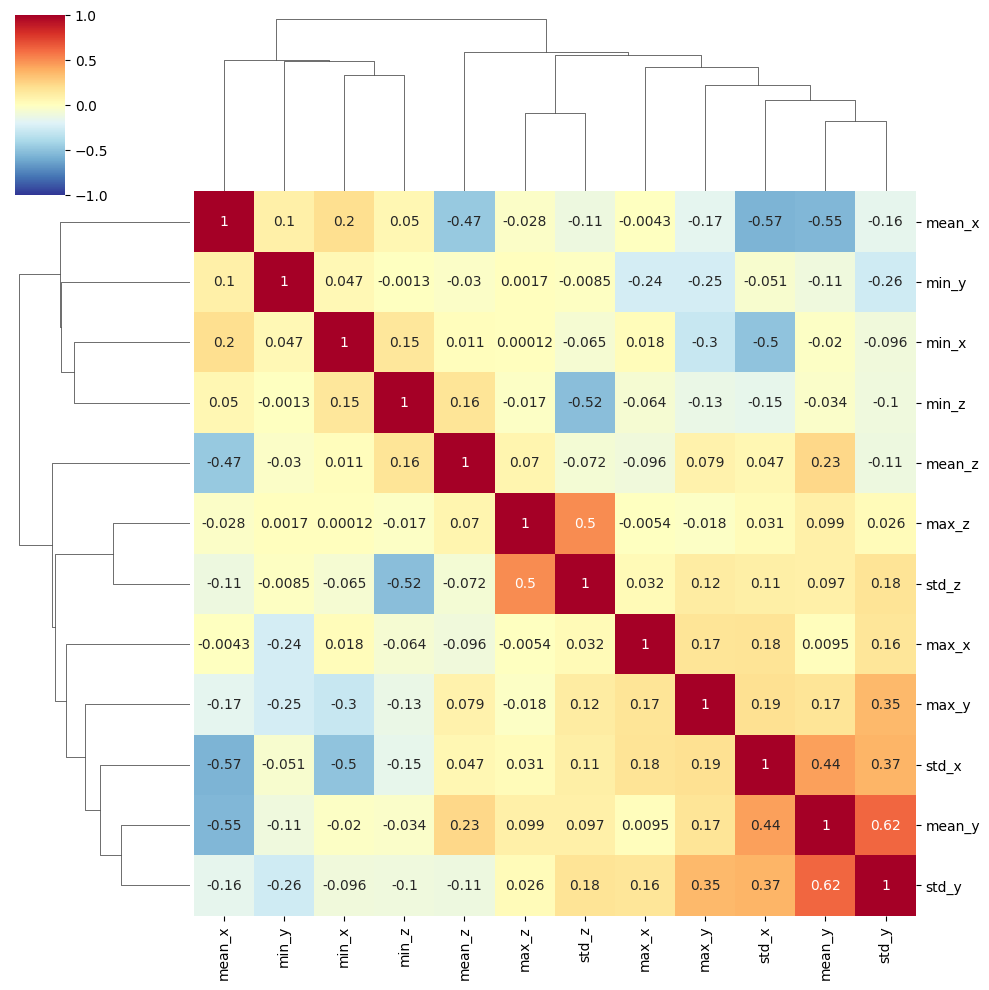

In [ ]:
sns.clustermap(df.corr(), annot = True, cmap='RdYlBu_r', vmin = -1, vmax = 1)

#### 결론
  * Y값의 mean과 std 유사도가 높음
  * 대부분 상관관계 없음이라 다 포함시킴

### FFT, AutoCorrelation 비교

In [ ]:
from scipy.fft import fft
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.signal import correlate
from scipy.spatial.distance import euclidean


from tqdm import tnrange, tqdm_notebook  #이터레이션 돌면서 얼마나 걸리는지를 보여줌.

import time



def extract_features(X_sample: np.ndarray) -> np.ndarray:
    """
    Extract features from a single sample

    Parameters
    ----------
    X_sample : array of shape (500, 3)
        100Hz * 5 seconds => 500
        3 axis (x, y, z)  => 3

    Returns
    -------
    features : array with (p,) shape
        Extracted features from X_sample
    """
    assert X_sample.shape != (500, 3)

    #################### TODO: Extract more features ####################

    # Extract time domain features
    X_fft = np.abs(np.fft.fft(X_sample, axis=0))[1:] # 시계열 데이터의 푸리에 변환(Fourier Transform)을 수행. 주기적인 패턴, 빈
    fft_mean = np.mean(X_fft, axis=0)
    fft_std = np.std(X_fft, axis=0)

    auto_correlations = np.real(fft(X_fft * np.conj(X_fft), axis=0)) # 시계열 데이터의 자기 상관을 계산
    auto_corr_mean = np.mean(auto_correlations, axis=0)
    auto_corr_max = np.max(auto_correlations, axis=0)
    auto_corr_median = np.median(auto_correlations, axis=0)

    features = np.hstack([
        fft_mean,
        fft_std,
        auto_corr_mean,
        auto_corr_max,
        auto_corr_median
    ])

    ######################################################################

    return features

In [ ]:
import seaborn as sns
import pandas as pd

features = extract_features(X)
print(features.shape)
df = pd.DataFrame(features)
df.columns = ['fft_mean_x', 'fft_mean_y', 'fft_mean_z',
              'fft_std_x', 'fft_std_y', 'fft_std_z',
              'auto_corr_mean_x', 'auto_corr_mean_y', 'auto_corr_mean_z',
              'auto_corr_max_x', 'auto_corr_max_y', 'auto_corr_max_z',
              'auto_corr_median_x', 'auto_corr_median_y', 'auto_corr_median_z']
df.head()

(500, 15)


,fft_mean_x,fft_mean_y,fft_mean_z,fft_std_x,fft_std_y,fft_std_z,auto_corr_mean_x,auto_corr_mean_y,auto_corr_mean_z,auto_corr_max_x,auto_corr_max_y,auto_corr_max_z,auto_corr_median_x,auto_corr_median_y,auto_corr_median_z
0,516.625132,618.402255,326.711679,521.423262,567.456931,323.988580,8.280848e+06,5.079951e+08,580625.097839,7.510107e+09,9.819032e+09,2.951013e+09,8.120327e+04,1.804209e+08,-3.173969e+06
1,506.618878,606.384676,332.637936,518.019355,559.496586,326.718027,8.508821e+06,4.861504e+08,475096.743758,7.318069e+09,9.488818e+09,3.030236e+09,2.335986e+04,1.650089e+08,-3.592630e+06
2,501.780215,620.078132,329.613779,515.520354,559.675309,327.626648,8.946876e+06,4.739061e+08,231489.309534,7.214054e+09,9.725705e+09,3.010607e+09,3.282578e+05,1.558590e+08,-3.559539e+06
3,507.327370,634.869646,332.687816,516.536185,571.021409,327.827755,8.629159e+06,4.681241e+08,224143.476960,7.306694e+09,1.016327e+10,3.040824e+09,1.098807e+06,1.480347e+08,-4.040015e+06
4,501.909661,648.292358,328.367143,516.105157,570.521062,330.391623,9.444320e+06,4.753771e+08,229529.623273,7.224275e+09,1.039539e+10,3.024534e+09,2.468122e+06,1.532413e+08,-3.750854e+06


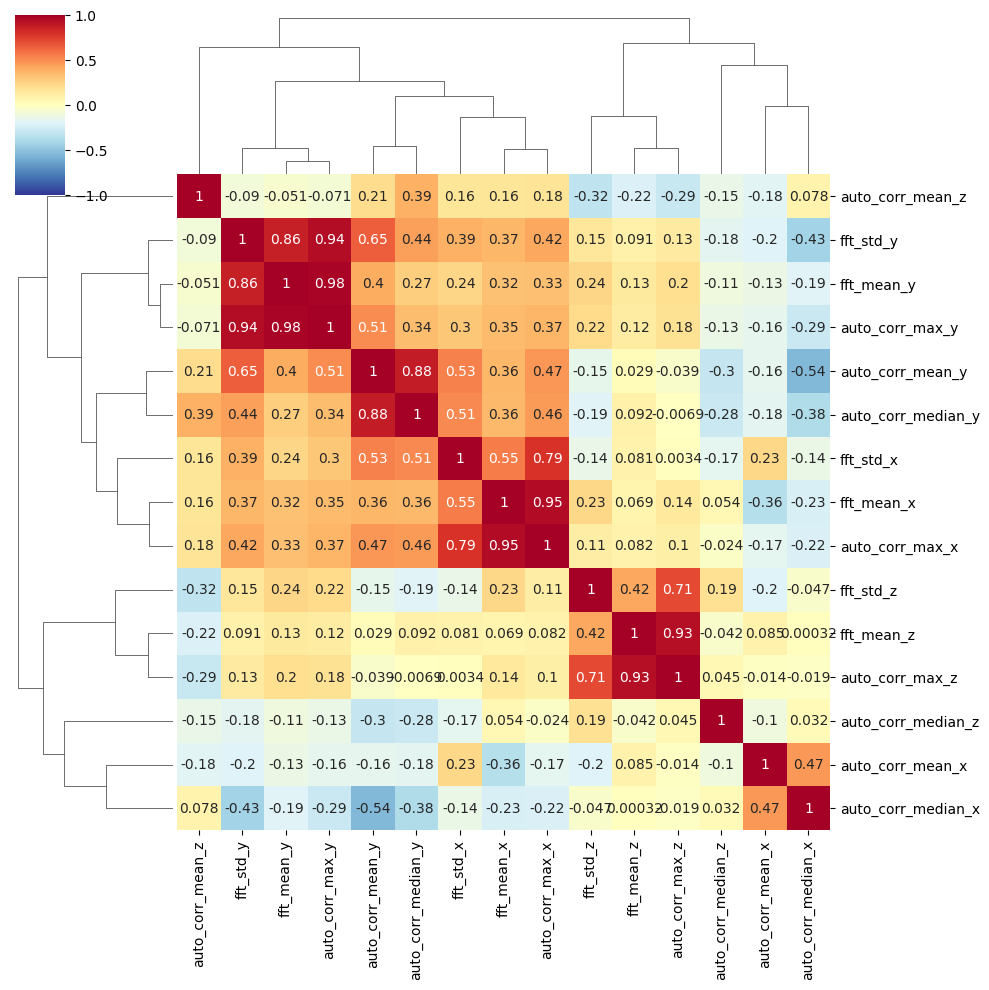

In [ ]:
sns.clustermap(df.corr(), annot = True, cmap='RdYlBu_r', vmin = -1, vmax = 1)

#### 결론
  * auto_corr과 fft 값이 유사하여 fft만 넣어도 될 듯?

### 외도, 척도, 파워, 에너지, 엔트로피

In [ ]:
from scipy.fft import fft
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.signal import correlate
from scipy.spatial.distance import euclidean


from tqdm import tnrange, tqdm_notebook  #이터레이션 돌면서 얼마나 걸리는지를 보여줌.

import time



def extract_features(X_sample: np.ndarray) -> np.ndarray:
    """
    Extract features from a single sample

    Parameters
    ----------
    X_sample : array of shape (500, 3)
        100Hz * 5 seconds => 500
        3 axis (x, y, z)  => 3

    Returns
    -------
    features : array with (p,) shape
        Extracted features from X_sample
    """
    assert X_sample.shape != (500, 3)

    #################### TODO: Extract more features ####################

    # Extract time domain features
    skewness_val = skew(X_sample, axis=0) # 데이터의 비대칭도
    kurtosis_val = kurtosis(X_sample, axis=0) # 데이터의 뾰족함
    # percentiles_val = np.percentile(X_sample, [25, 50, 75], axis=0)
    power_val = np.sum(X_sample**2, axis=0) / len(X_sample) # 시계열 데이터의 전력을 계산합니다. 여기서 전력은 신호의 제곱의 평균
    energy_val = np.sum(X_sample**2, axis=0)

    # 엔트로피 계산
    prob_data = X_sample - np.min(X_sample, axis=0)  # 음수 값 제거
    prob_data = prob_data / np.sum(prob_data, axis=0)  # 정규화
    entropy_val = -np.sum(prob_data * np.log2(prob_data + np.finfo(float).eps), axis=0)  # 0 로그 0 문제 방지

    features = np.hstack([
        skewness_val,
        kurtosis_val,
        # percentiles_val,
        energy_val,
        entropy_val
    ])

    ######################################################################

    return features

In [ ]:
import seaborn as sns
import pandas as pd

features = extract_features(X)
print(features.shape)
df = pd.DataFrame(features)
df.columns = ['skewness_x', 'skewness_y', 'skewness_z',
              'kurtosis_x', 'kurtosis_y', 'kurtosis_z',
              # 'percentiles_val_x', 'percentiles_val_y', 'percentiles_val_z',
              'energy_val_x', 'energy_val_y', 'energy_val_z',
              'entropy_val_x', 'entropy_val_y', 'entropy_val_z']
df.head()

(500, 12)


,skewness_x,skewness_y,skewness_z,kurtosis_x,kurtosis_y,kurtosis_z,energy_val_x,energy_val_y,energy_val_z,entropy_val_x,entropy_val_y,entropy_val_z
0,-0.668370,1.945953,-0.657700,7.909740,39.217714,6.889889,898111.950828,822586.646414,406759.785797,13.762860,13.758905,13.761831
1,-0.553351,1.477559,-0.968893,7.749596,31.880310,10.421611,881457.289302,798765.510294,411893.976099,13.763664,13.759010,13.763667
2,-0.294724,2.413843,-1.492614,4.107357,44.164998,15.040285,871214.781617,817920.479686,409344.722770,13.760755,13.759598,13.763633
3,-0.373804,2.740951,-0.948196,5.632083,53.646214,9.728522,877278.865100,850686.658090,411103.984695,13.762853,13.761417,13.762495
4,-0.238565,3.006140,-1.001218,3.056938,55.457316,8.548571,872789.889726,868909.544038,410390.898579,13.757834,13.758761,13.762963


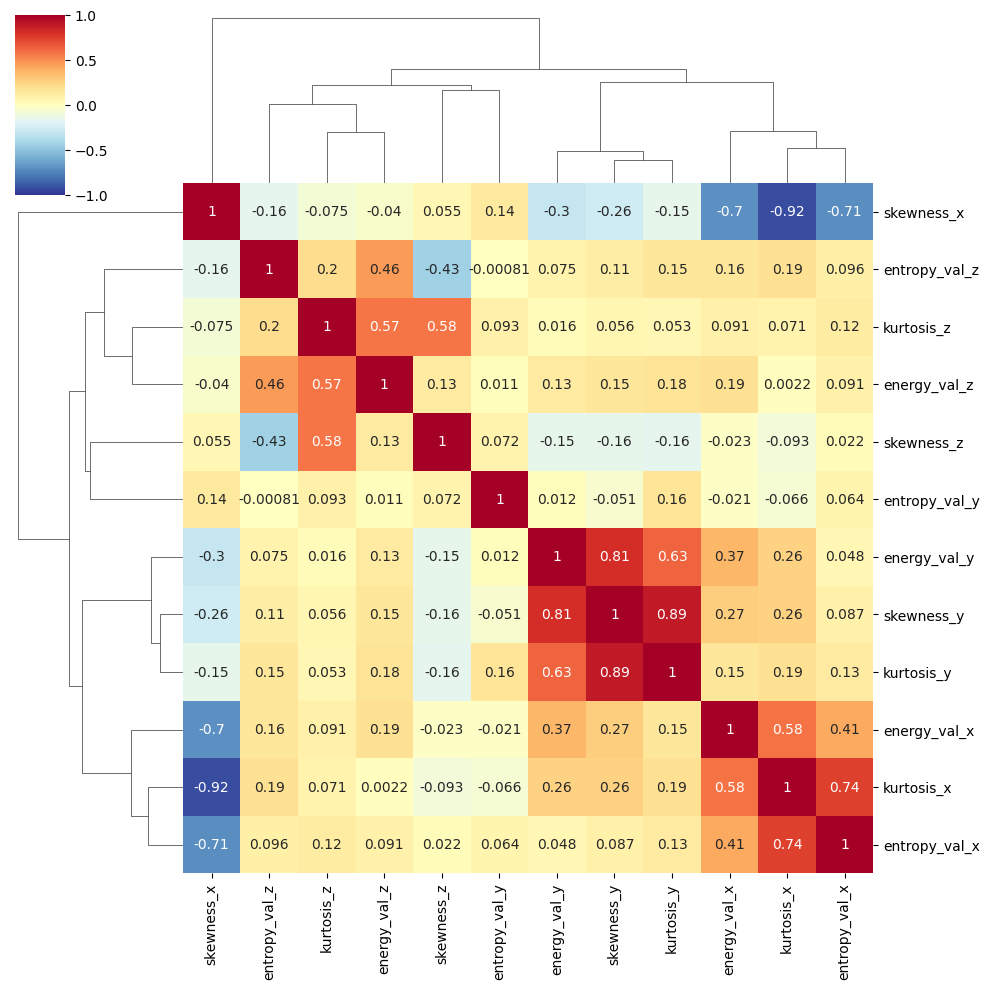

In [ ]:
sns.clustermap(df.corr(), annot = True, cmap='RdYlBu_r', vmin = -1, vmax = 1)

#### 결론
  * 외도와 척도가 유사하여 제외해도 될 듯 --> Skewness만 포함?
  * 척도와 energy가 유사한데, 외도와 척도도 유사함 --> Skewness만 포함?
  * energy와 entropy가 유사하여 둘 중 하나만 넣기? --> entropy만 포함?
  

### 최종 함수?

In [6]:
from scipy.fft import fft
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.signal import correlate
from scipy.spatial.distance import euclidean


from tqdm import tnrange, tqdm_notebook  #이터레이션 돌면서 얼마나 걸리는지를 보여줌.

import time



def extract_features(X_sample: np.ndarray) -> np.ndarray:
    """
    Extract features from a single sample

    Parameters
    ----------
    X_sample : array of shape (500, 3)
        100Hz * 5 seconds => 500
        3 axis (x, y, z)  => 3

    Returns
    -------
    features : array with (p,) shape
        Extracted features from X_sample
    """
    #assert X_sample.shape != (500, 3)

    #################### TODO: Extract more features ####################
    X_fft = np.abs(np.fft.fft(X_sample, axis=0))[1:] # 시계열 데이터의 푸리에 변환(Fourier Transform)을 수행. 주기적인 패턴, 빈
    fft_mean = np.mean(X_fft, axis=0)
    fft_std = np.std(X_fft, axis=0)

    mean_val = np.mean(X_sample, axis=0)
    min_val = np.min(X_sample, axis=0)
    max_val = np.max(X_sample, axis=0)
    std_dev = np.std(X_sample, axis=0)

    skewness_val = skew(X_sample, axis=0) # 데이터의 비대칭도

    # 엔트로피 계산
    prob_data = X_sample - np.min(X_sample, axis=0)  # 음수 값 제거
    prob_data = prob_data / np.sum(prob_data, axis=0)  # 정규화
    entropy_val = -np.sum(prob_data * np.log2(prob_data + np.finfo(float).eps), axis=0)  # 0 로그 0 문제 방지

    features = np.hstack([
        fft_mean, fft_std,
        mean_val, min_val, max_val, std_dev,
        skewness_val, entropy_val
    ])

    ######################################################################

    return features

In [7]:
import seaborn as sns
import pandas as pd

features = extract_features(X)
print(features.shape)
df = pd.DataFrame(features)
df.columns = ['fft_mean_x', 'fft_mean_y', 'fft_mean_z',
              'fft_std_x', 'fft_std_y', 'fft_std_z',
              'mean_x', 'mean_y', 'mean_z',
              'min_x', 'min_y', 'min_z',
              'max_x', 'max_y', 'max_z',
              'std_dev_x', 'std_dev_y', 'std_dev_z',
              'skewness_x', 'skewness_y', 'skewness_z',
              'entropy_x', 'entropy_y', 'entropy_z']
df.head()

(500, 24)


,fft_mean_x,fft_mean_y,fft_mean_z,fft_std_x,fft_std_y,fft_std_z,mean_x,mean_y,mean_z,min_x,...,max_z,std_dev_x,std_dev_y,std_dev_z,skewness_x,skewness_y,skewness_z,entropy_x,entropy_y,entropy_z
0,516.625132,618.402255,326.711679,521.423262,567.456931,323.988580,-5.077356,2.912010,3.740755,-89.196503,...,43.650600,6.216705,7.108395,3.896932,-0.668370,1.945953,-0.657700,13.762860,13.758905,13.761831
1,506.618878,606.384676,332.637936,518.019355,559.496586,326.718027,-5.056980,2.910373,3.735488,-97.437897,...,40.247700,6.136708,6.987845,3.948894,-0.553351,1.477559,-0.968893,13.763664,13.759010,13.763667
2,501.780215,620.078132,329.613779,515.520354,559.675309,327.626648,-5.037217,2.936892,3.724514,-71.700104,...,24.842501,6.092940,7.074533,3.936083,-0.294724,2.413843,-1.492614,13.760755,13.759598,13.763633
3,507.327370,634.869646,332.687816,516.536185,571.021409,327.827755,-5.033074,2.953660,3.720580,-87.516197,...,42.900700,6.131937,7.231927,3.955787,-0.373804,2.740951,-0.948196,13.762853,13.761417,13.762495
4,501.909661,648.292358,328.367143,516.105157,570.521062,330.391623,-5.043208,2.972685,3.724968,-60.099098,...,38.034599,6.097255,7.314045,3.945177,-0.238565,3.006140,-1.001218,13.757834,13.758761,13.762963


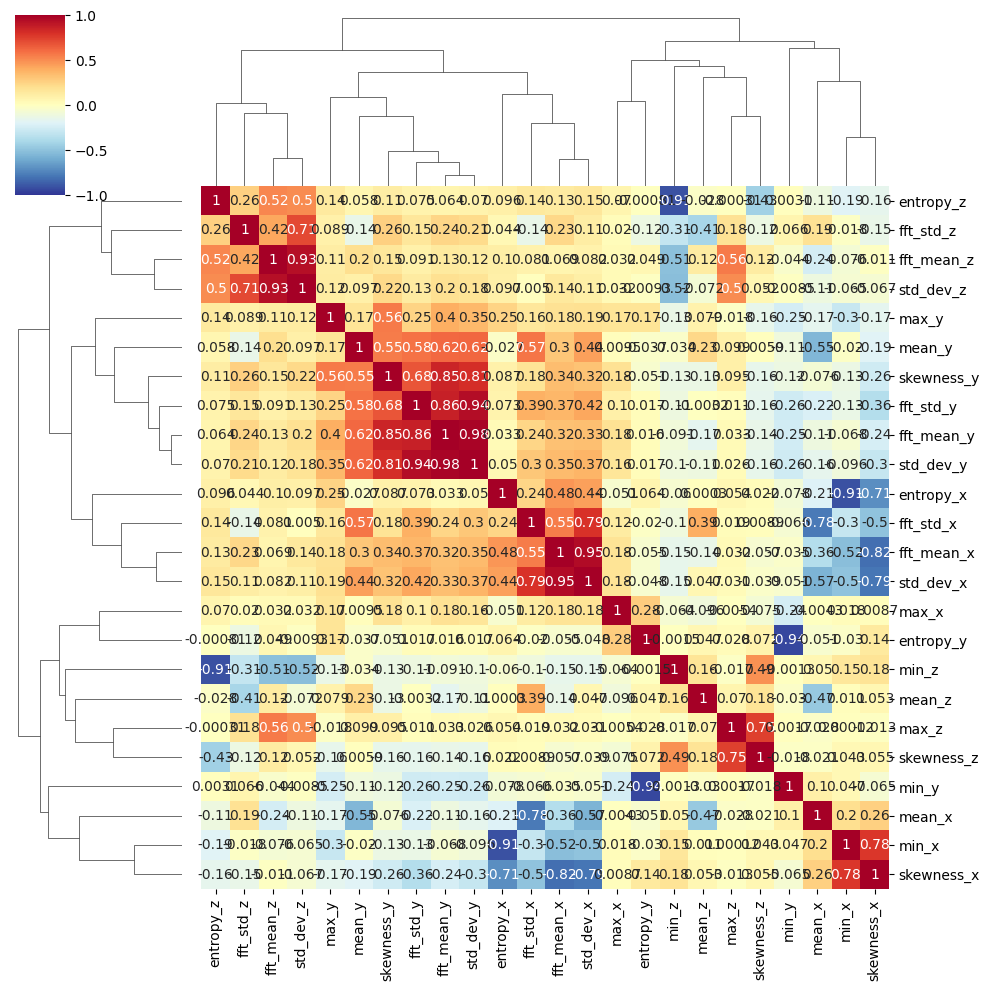

In [8]:
sns.clustermap(df.corr(), annot = True, cmap='RdYlBu_r', vmin = -1, vmax = 1)

### 4. Classifiers

In [12]:
# Extract features for multiple samples
X_features = np.array([
    extract_features(X_sample)
    for X_sample in X
])
print(X_features.shape)
print(Y.shape)

(13940, 24)
(13940,)


In [13]:
#################### TODO: Implement your own classifiers ####################

import numpy as np
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.svm as svm
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler


LRClassifier = None
LDAClassifier = None
RFClassifier = None
BClassifier = None
SVMClassifier = None

LRClassifier = Pipeline([
    # ('feature_extractor', FunctionTransformer(extract_features)),
    ('scaler', StandardScaler()),
    ('preprocessor', PCA()),
    ('classifier', LogisticRegression(max_iter=10000, solver='saga'))
])

LDAClassifier = Pipeline([
    # ('feature_extractor', FunctionTransformer(extract_features)),
    ('normalizer', StandardScaler()),
    ('preprocessor', PCA()),
    ('classifier', LinearDiscriminantAnalysis())
])

RFClassifier = Pipeline([
    # ('feature_extractor', FunctionTransformer(extract_features)),
    ('normalizer', StandardScaler()),
    ('preprocessor', PCA()),
    ('classifier', RandomForestClassifier(criterion='entropy', bootstrap=True, random_state=42, max_depth=5))
])

# BClassifier = Pipeline([
#     ('feature_extractor', FunctionTransformer(extract_features)),
#     ('normalizer', StandardScaler()),
#     ('preprocessor', PCA()),
#     ('classifier', BayesianRidge())
# ])

SVMClassifier = Pipeline([
    # ('feature_extractor', FunctionTransformer(extract_features)),
    ('normalizer', StandardScaler()),
    ('preprocessor', PCA()),
    ('classifier', svm.SVC(kernel = 'linear'))
])




##############################################################################

### 5. Cross-validation with Subjects

In [15]:
# for clf in [LRClassifier, LDAClassifier, RFClassifier, BClassifier, SVMClassifier]:
for clf in [LRClassifier, LDAClassifier, RFClassifier, BClassifier, SVMClassifier]:
# for clf in [LRClassifier]:
    scores = cross_val_score(
        clf,
        X_features, Y,
        groups=Subjects,        # Provide subjects for subject-wise cross-validation
        cv=LeaveOneGroupOut(),  # Subject-wise cross-validation
        scoring='f1_macro',     # Scoring with macro F1 score
        n_jobs=1,              # Enable multiprocessing
        verbose=10,             # Print processing logs
    )
    print(np.mean(scores))

[CV] START .....................................................................
[CV] END ................................ score: (test=0.473) total time=  26.5s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   26.5s


[CV] END ................................ score: (test=0.491) total time=  19.4s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.576) total time=  19.5s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.705) total time=  24.5s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:  1.5min


[CV] END ................................ score: (test=0.691) total time=  21.6s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.446) total time=  21.1s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.257) total time=  26.4s
0.5200199729058249
[CV] START .....................................................................
[CV] END ................................ score: (test=0.608) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:  2.7min
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:  2.7min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.2s


[CV] END ................................ score: (test=0.521) total time=   0.1s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.569) total time=   0.2s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.710) total time=   0.2s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.7s


[CV] END ................................ score: (test=0.560) total time=   0.2s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.438) total time=   0.2s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.072) total time=   0.2s
0.4968164454101533
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    1.3s


[CV] END ................................ score: (test=0.374) total time=   8.3s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    8.3s


[CV] END ................................ score: (test=0.577) total time=   6.9s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.468) total time=   7.7s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.631) total time=   7.6s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   30.5s


[CV] END ................................ score: (test=0.580) total time=   8.3s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.508) total time=   7.8s
[CV] START .....................................................................
[CV] END ................................ score: (test=0.006) total time=   8.6s
0.44914869295606435


[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:   55.2s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:   55.2s


TypeError: ignored